In [95]:
import phys
import numpy as np

class SNCompanionCollision(object):
    
    def __init__(self, a=1e13, M=phys.sm, v=1e9, kappa=0.2):
        """
        parameters:
            a: binary separation in cm (default value: 1e13)
            M: ejecta mass in gram (default value: one solar mass)
            v: expansion velocity in cm/s (default value: 1e9)
            kappa: opacity in cm^2/gram (default value: 0.2)
        """
        self.a = a / 1e13
        self.M = M / phys.sm
        self.v = v / 1e9
        self.kappa = kappa / 0.2
    
    def _AngularDependence(self, theta):
        """
        This function uses the parameterization of eq. (3) in Brown et al. 2012, ApJ, 749, 18
        parameters:
            theta: viewing angle in degrees
        return paramters:
            angular dependence factor
        """
        theta_rad = theta * 0.01745
        return 0.2075 * (0.5 * np.cos(theta_rad) + 0.5) *\
            (0.14 * theta_rad * theta_rad - 0.4 * theta_rad + 1) * np.cos(theta_rad)
        
    def _DerivedEquation(self, t):
        """
        Eqs. (22) and (25)
        parameter:
            t: in units of days after explosion
        return parameters:
            luminosity: luminosity in ergs/s
            temperature: temperature in kelvin
        """
        luminosity = 1e43 * self.a * self.M**(0.25) * self.v**(1.75) * self.kappa**(-0.75) * t**(-0.5)
        temperature = 2.5e4 * self.a**(0.25) * self.kappa**(-35. / 36) * t**(-37. / 72)
        return luminosity, temperature
    
    def _PlanckFunction(self, wavelength, temperature):
        """
        parameters:
            wavelength: wavelength in Angstrom
            temperature: thermal temperature in Kelvin
        return paramters:
            flux density in ergs/s/cm^2/ster/Angstrom
        """
        factor = phys.h * phys.c / (wavelength * 1e-8 * phys.k * temperature)
        flux = 2. * phys.h * phys.c * phys.c / (wavelength * 1e-8)**5 /\
            (np.exp(factor) - 1) * 1e-8
        return flux
    
    def Spectrum(self, t, theta):
        """
        parameters:
            t: in units of days after explosion
            theta: viewing angle in degrees
        return parameters:
            a function to calculate spectrum at a given wavelength in units of ergs/s/ster/Angstrom
        """
        luminosity, temperature = self._DerivedEquation(t)
        f = self._AngularDependence(theta)
        func = lambda wavelength: f * luminosity * np.pi * self._PlanckFunction(wavelength, temperature) /\
                                  (phys.sigma * temperature**4)
        return func

In [107]:
from scipy import interpolate
from scipy import integrate

class Filter(object):
    
    def __init__(self, name, wavelength, transmission):
        """
        parameters:
            name: filter name
            wavelength: wavelength in Angstrom
            tranmission: in the units of per Angstrom per photon
        """
        self.name = name
        self.wavelength = wavelength
        self.transmission = transmission
        norm = integrate.quad(self._TransmissionInterpolation(),
                              self.wavelength.min(),
                              self.wavelength.max())[0]
        self.transmission /= norm
        self.wavelength_eff = 1 /\
            integrate.quad(interpolate.interp1d(self.wavelength,
                                                self.transmission,
                                                bounds_error=False,
                                                fill_value=0),
                           self.wavelength.min(),
                           self.wavelength.max())[0]
        
    def _TransmissionInterpolation(self):
        return interpolate.interp1d(self.wavelength, 
                                    self.transmission * self.wavelength, 
                                    bounds_error=False, 
                                    fill_value=0)
    
    def TransmissionCurve(self, wv):
        return self._TransmissionInterpolation()(wv)

In [108]:
import extinction_cal

class Spectrum(object):
    
    def __init__(self, wavelength, flux):
        self.wavelength = wavelength
        self.flux = flux
        
    def extinction(self, EBV, RV=3.1):
        A = extinction_cal.calALambda(self.wavelength, RV, EBV)
        self.flux *= 10**(-A/2.5)
        
    def redshift(self, z):
        self.wavelength *= (1 + z)
        self.flux /= (1 + z)
        
    def SyntheticPhotometry(self, filter_curve):
        func = lambda wv: interpolate.interp1d(self.wavelength,
                                               self.flux * filter_curve.TransmissionCurve(self.wavelength),
                                               bounds_error=False,
                                               fill_value=0)(wv)
        return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]

In [109]:
# apply it to iPTF16abc
z = 0.00232
mu = 34.66
dist = 10**((mu - 25) / 5) * phys.Mpc
t = 0.18  # days. First detection of iPTF16abc
mag = 21.4  # mag. First mag of iPTF16abc
local_EBV = 0.361
galactic_EBV = 0.0279

In [128]:
def ObservedMagnitude(model, theta, filter_curve, redshift=z):
    wv = filter_curve.wavelength / (1 + z)
    spec_func = model.Spectrum(t, theta)
    spec = Spectrum(wv, spec_func(wv))
    spec.extinction(local_EBV)
    spec.redshift(redshift)
    spec.flux /= (4. * np.pi * dist * dist)
    spec.extinction(galactic_EBV)
    obs_flux = spec.SyntheticPhotometry(filter_curve)  # F_lambda
    obs_flux *= filter_curve.wavelength_eff * (filter_curve.wavelength_eff * 1e-8 / phys.c) * 1e23  # F_nu in Jy
    return -2.5 * np.log10(obs_flux / 3631)  # AB mag

In [129]:
# g-band filter
data = np.genfromtxt('../data/filters/P48/P48_g.dat', 
                     names=["wavelength", "transmission"])
filter_curve = Filter("P48_g", data["wavelength"], data["transmission"])

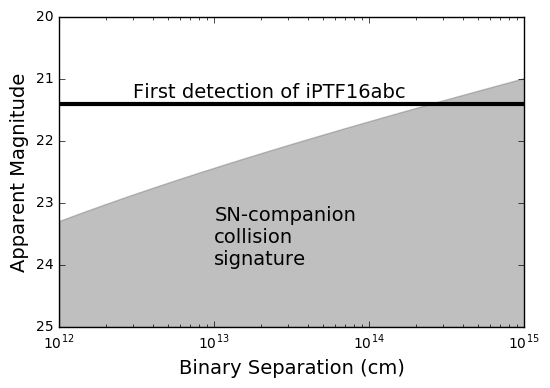

In [162]:
from scipy import optimize

a_list = 10**np.linspace(12, 15, 21)
mag_list = np.ndarray(a_list.shape)
for i in range(len(a_list)):
    a = a_list[i]  # cm
    model = SNCompanionCollision(a=a, M=1.4*phys.sm)
    func = lambda theta:\
        ObservedMagnitude(model, theta, filter_curve)
    mag_list[i] = func(0)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log")
ax.fill_between(a_list, mag_list, 25, color='gray', alpha=0.5)
ax.hlines(mag, *ax.get_xlim(), color='k', linewidth=3)
ax.text(1e13, 24, "SN-companion\ncollision\nsignature", fontsize=14)
ax.text(3e12, 21.3, "First detection of iPTF16abc", fontsize=14)
ax.set_ylim((25, 20))
ax.set_xlabel("Binary Separation (cm)", fontsize=14)
ax.set_ylabel("Apparent Magnitude", fontsize=14)

plt.savefig("SNCompanion.pdf")